#Starting with Data

In [26]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import time 
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


**Importing File**

In [28]:
dfs = pd.read_csv("/content/MRF.NS.csv")

dfs.shape()

In [29]:
dfs.head(5)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-07-01,910.0,910.0,880.0,897.599976,815.772827,426.0
1,2002-07-02,900.0,905.0,895.0,903.650024,821.271484,310.0
2,2002-07-03,910.0,910.0,900.0,906.700012,824.043396,336.0
3,2002-07-04,920.0,925.0,910.0,916.799988,833.222717,591.0
4,2002-07-05,915.0,935.0,910.0,927.299988,842.765442,1623.0


**Now Make sure that the datatype of dataset 
aligns with the compatibility of ARIMA model.**

1:Make 'Date' Attribute in dataset of DateTime format
(Date dataset may be of String format)

Check date type as follows

In [30]:
type(dfs.Date[0])

str

If the date format is in **string** we need to convert it into **dateTime** format as follows

In [31]:
dfs['Date'] = pd.to_datetime(dfs['Date'], format='%Y-%m-%d')

Now again check **Date** type

In [32]:
type(dfs.Date[0])

pandas._libs.tslibs.timestamps.Timestamp

Above is the correct data type

**Split Data** 

In [33]:
n = int(len(dfs)*239/240)
df = dfs[:n]
test_data = dfs[n:]
test_data['Date'] = pd.to_datetime(test_data['Date'], format='%Y-%m-%d')
test_data = test_data.groupby('Date')[['Close']].mean()

#Exploratory Data Anylysis



1:Detect and Remove Null Values

2:Group only the relevant attributes from the dataset, that is, ‘Date’ and ‘Close’. **Using "groupby() function"**


In [34]:
#check number of null values
df.isnull().sum()

Date          0
Open         10
High         10
Low          10
Close        10
Adj Close    10
Volume       10
dtype: int64

In [35]:
#looking null cells
df[df.isna().any(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume
205,2003-04-14,NaN,NaN,NaN,NaN,NaN,NaN
475,2004-04-26,NaN,NaN,NaN,NaN,NaN,NaN
597,2004-10-13,NaN,NaN,NaN,NaN,NaN,NaN
1913,2010-02-06,NaN,NaN,NaN,NaN,NaN,NaN
2391,2012-01-07,NaN,NaN,NaN,NaN,NaN,NaN
2430,2012-03-03,NaN,NaN,NaN,NaN,NaN,NaN
2560,2012-09-08,NaN,NaN,NaN,NaN,NaN,NaN
2602,2012-11-11,NaN,NaN,NaN,NaN,NaN,NaN
2939,2014-03-22,NaN,NaN,NaN,NaN,NaN,NaN
3168,2015-02-28,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
#dropping null cells
df1=df.dropna()
df1.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-07-01,910.0,910.0,880.0,897.599976,815.772827,426.0
1,2002-07-02,900.0,905.0,895.0,903.650024,821.271484,310.0
2,2002-07-03,910.0,910.0,900.0,906.700012,824.043396,336.0
3,2002-07-04,920.0,925.0,910.0,916.799988,833.222717,591.0
4,2002-07-05,915.0,935.0,910.0,927.299988,842.765442,1623.0


In [37]:
#groupby()
df2 = df1.groupby('Date')[['Close']].mean()
df2.head(5)

,Close
Date,
2002-07-01,897.599976
2002-07-02,903.650024
2002-07-03,906.700012
2002-07-04,916.799988
2002-07-05,927.299988


#Stationarity Test and Finding p,q and d manually

A data is said to be stationary if the mean variance and autocorrelation structure do not show any difference over time.

**Augmented Dickey Fuller Test**

In [38]:
#Check if price series is stationary
result = adfuller(df2.Close)
print(f"ADF Statistics: {result[0]}")
print(f"p-value       : {result[1]}")

ADF Statistics: -0.3120765668275242
p-value       : 0.9237764284084519


***p-value greter than 0.05 suggest that series is not stationary***

**Autocorretional Function (ACF)**

i.e. To find Order of Differentiating  **"d"**

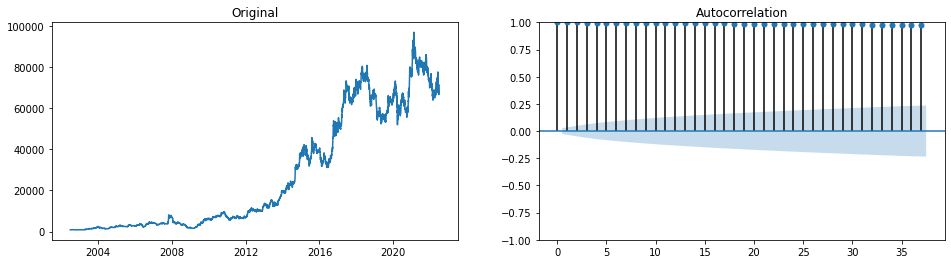

In [39]:
#original graph of data and acf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(df2.Close)
ax1.set_title('Original')
#add ; to end of the plot function so that the plot is not duplicated
plot_acf(df2.Close, ax = ax2);

Clearly From graph also we can see that graph is not stationary

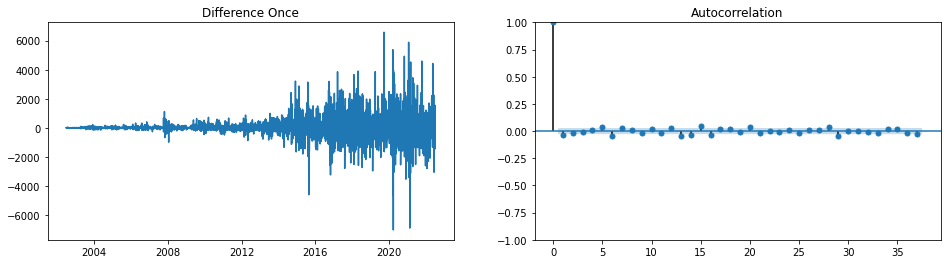

In [40]:
#Differenced Once
diff = df2.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title('Difference Once')
#add ; to end of the plot function so that the plot is not duplicated
plot_acf(diff, ax = ax2);

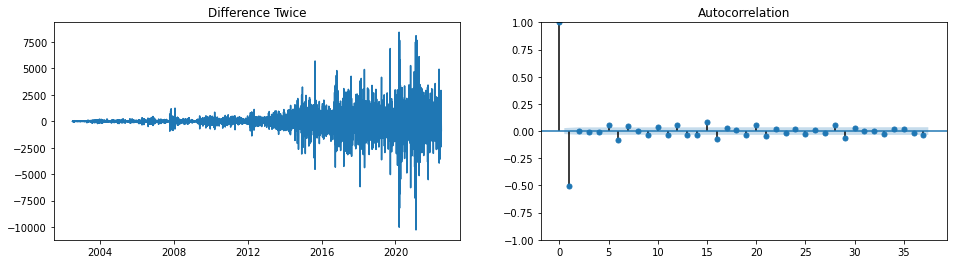

In [41]:
#Differenced Twice
diff = df2.Close.diff().diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title('Difference Twice')
#add ; to end of the plot function so that the plot is not duplicated
plot_acf(diff, ax = ax2);

d=1 may be good choice
Lets also check d vlue using pmdarima package 

In [42]:
from pmdarima.arima.utils import ndiffs


In [43]:
ndiffs(df2.Close,test="adf")

1

Cross check above with d value that we got earlier

**Next part is to find "auto regressiver" term i.e. "p" term**

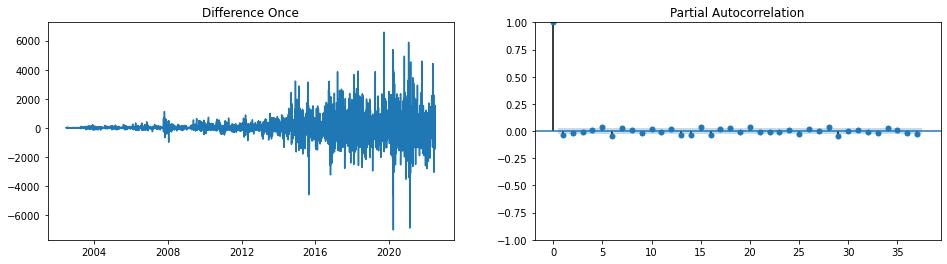

In [44]:
diff = df2.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title('Difference Once')
ax2.set_ylim(0, 1)
#add ; to end of the plot function so that the plot is not duplicated
plot_pacf(diff, ax = ax2);

p=3 may be a good choice

**Finding "MA" i.e. "q" term**

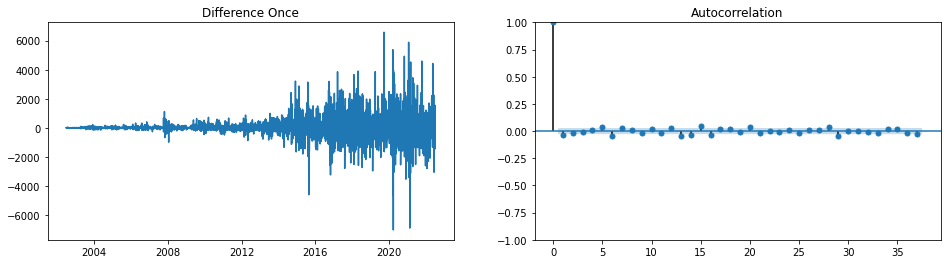

In [45]:
diff = df2.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title('Difference Once')
ax2.set_ylim(0, 1)
#add ; to end of the plot function so that the plot is not duplicated
plot_acf(diff, ax = ax2);

q=1,2,3,4 are all close values so we will decide by autu arima model

# AUTO-ARIMA

In [48]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [49]:
result = auto_arima(df2.Close, trace=True,supress_warnings=True)
print(result.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=78587.072, Time=2.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=78585.876, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=78582.530, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=78582.350, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=78586.158, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=78583.715, Time=2.84 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=78583.069, Time=1.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=78585.064, Time=4.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=78582.792, Time=0.49 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 12.394 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4967
Model:               SARIMAX(0, 1, 1)   Log Likelihood              -39288.175
Date:                Tue, 26 Jul 2022  

#Fitting Model & making Prediction

In [50]:
from statsmodels.tsa.arima.model import ARIMA

In [51]:
model = ARIMA(diff,order=(0,1,1))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 4966
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -39287.763
Date:                Tue, 26 Jul 2022   AIC                          78579.527
Time:                        19:41:22   BIC                          78592.547
Sample:                             0   HQIC                         78584.092
                               - 4966                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9997      0.001  -1731.777      0.000      -1.001      -0.999
sigma2      4.342e+05   2791.491    155.530      0.000    4.29e+05     4.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   5.39   Jarque-Bera (JB):             62129.18
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):             130.07   Skew:                             0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Make Prediction On Test Set**

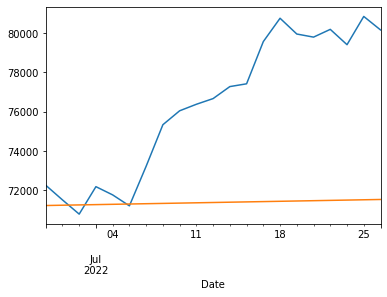

In [52]:
start1=len(diff)
end1 = len(diff) + len(test_data) -1

pred=model.predict(start=start1,end=end1,typ='levels').rename('ARIMA predictions')
pred.index=test_data.index
pred_cumsum=pred.cumsum()
final_preds=pred_cumsum + df2.Close[-1]
test_data["Close"].plot()
final_preds.plot()
# pred.plot(legend=True)
# test_data['Close'].plot(legend=True)
